In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, CubicSpline, interp1d
from scipy.optimize import curve_fit
import time
import scipy


from openparticle.hamiltonians.free_hamiltonians import free_boson_Hamiltonian, free_fermion_Hamiltonian
from openparticle.hamiltonians.yukawa_hamiltonians import *
from openparticle.hamiltonians.renormalized_yukawa_hamiltonian import *
from openparticle.utils import *
from openparticle.dlcq import momentum_states_partition, pdf, fock_sector_budget
from yukawa_utils import *

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24
plt.rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_Q_nonzero_sector_basis(resolution, n_fermions, n_bosons):
    partitions = find_exact_partitions(resolution)
    good_paritions = []

    for tup in partitions:
        n_fermions_in_partition = len(tup[0])
        n_antifermions_in_partition = len(tup[1])
        n_bosons_in_partition = len(tup[2])

        if (
            n_fermions_in_partition == n_fermions
            and n_bosons_in_partition == n_bosons
            and n_antifermions_in_partition == 0
        ):
            good_paritions.append(tup)

    states = []
    for p in good_paritions:
        states.append(
            Fock(
                f_occ=fermion_partition_to_f_occ(p[0]),
                af_occ=fermion_partition_to_f_occ(p[1]),
                b_occ=boson_partition_to_b_occ(p[2]),
            )
        )

    return states

In [3]:
#For odd number of fermions, need odd resolution

In [32]:
max_res = 20
mf = 1
mb = 0.5
g = 1
t = 1e-7


basis = (
    get_Q_nonzero_sector_basis(resolution=max_res, n_fermions = 2, n_bosons = 0)
    + get_Q_nonzero_sector_basis(resolution=max_res, n_fermions = 2, n_bosons = 1)
)

resolutions = [max_res]
renormalized_eigenvalues, renormalized_eigenvectors = get_renormalized_eigenstates(resolutions, t = t, g = g, 
                                                                                   mf = mf, mb = mb,
                                                                                   basis = basis,
                                                                                   return_focks = True, 
                                                                                   num_eigenstates = 'all',
                                                                                   verbose = True, 
                                                                                   assert_positivity = True)

---K =  20 ---
Time of renormalized_yukawa_second_order_form_factor: 9.486227035522461
Time of boson_exchange: 8.766529083251953
Time of fermion_exchange: 14.281956911087036
Time of fermion_self_energy (with loop): 0.039112091064453125
Time of antifermion_self_energy (with loop): 0.0401458740234375
Time of boson_self_energy (with loop): 0.033531904220581055
Size of Hamiltonian: 72956
Hamiltonian generated in: 33.69281005859375
Generating 100 x 100 Matrix...
Matrix generated in: 208.25460290908813
Calculating eigenvalues...
Eigenvalues calculated in: 0.007922887802124023
Time to 'Fockify': 1.7378008365631104


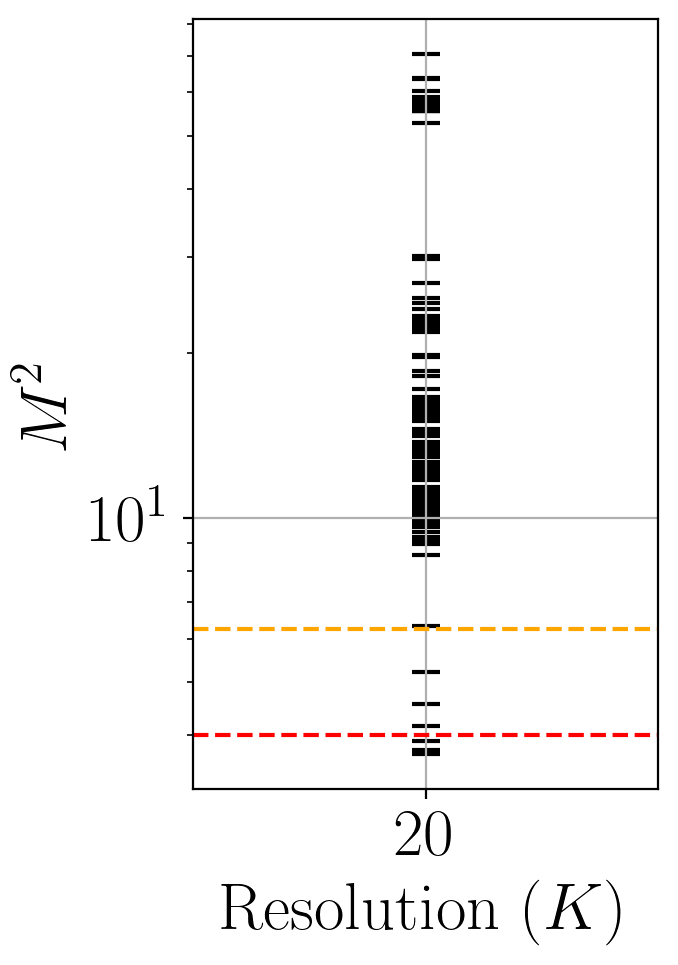

In [34]:
plt.figure(figsize = (3, 5), dpi = 200)
colors = plt.cm.viridis(np.linspace(0, 1, renormalized_eigenvalues.shape[0]))
for i, eig in enumerate(renormalized_eigenvalues):
    plt.scatter(resolutions, (eig), color = 'black', marker='_', s = 100)

plt.xlabel("Resolution ($K$)")
plt.ylabel("$M^2$")

plt.axhline(y = (2 * mf + 0 * mb)**2, color = 'red', linestyle = '--') 
plt.axhline(y = (2 * mf + 1 * mb)**2, color = 'orange', linestyle = '--') 

# plt.title(f'$\log_{{10}}t = {int(np.log10(t))}$,$g = {g}$, $m_f$ = {mf}, $m_b$ = {mb}')
plt.yscale('log')
plt.xticks(resolutions)
plt.grid()

In [47]:
fock_sector_budget(renormalized_eigenvectors[0])

{(0, 0, 0): 0.0, (2, 0, 0): 0.8280105254428294, (2, 0, 1): 0.1719894745571705}

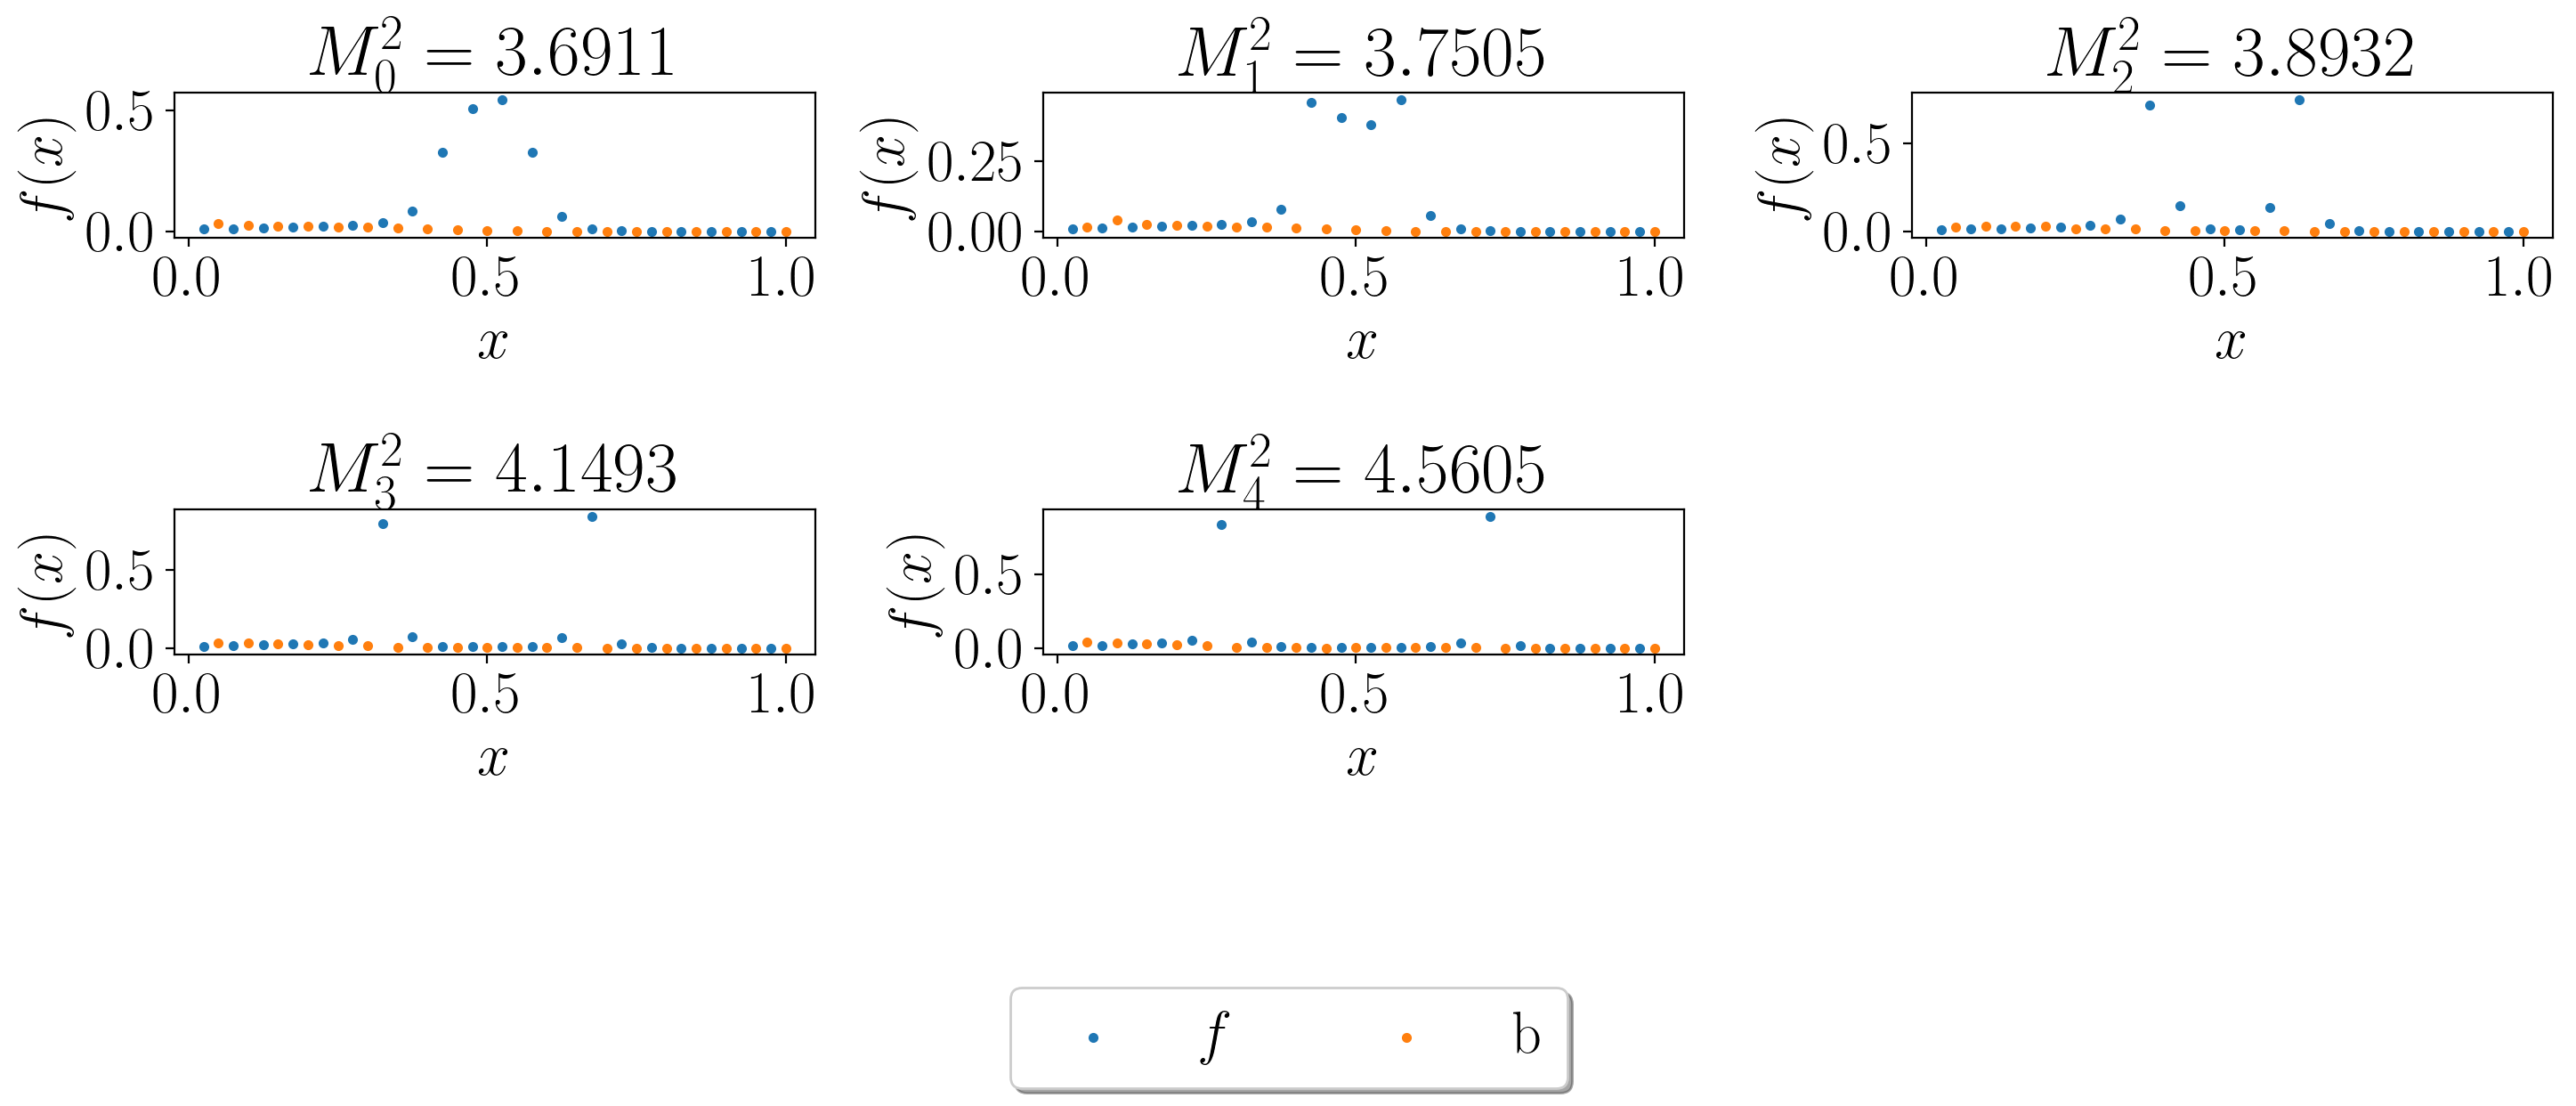

In [37]:
get_pdfs(max_res, renormalized_eigenvalues, renormalized_eigenvectors, 5)

Text(0, 0.5, '$xf(x)$')

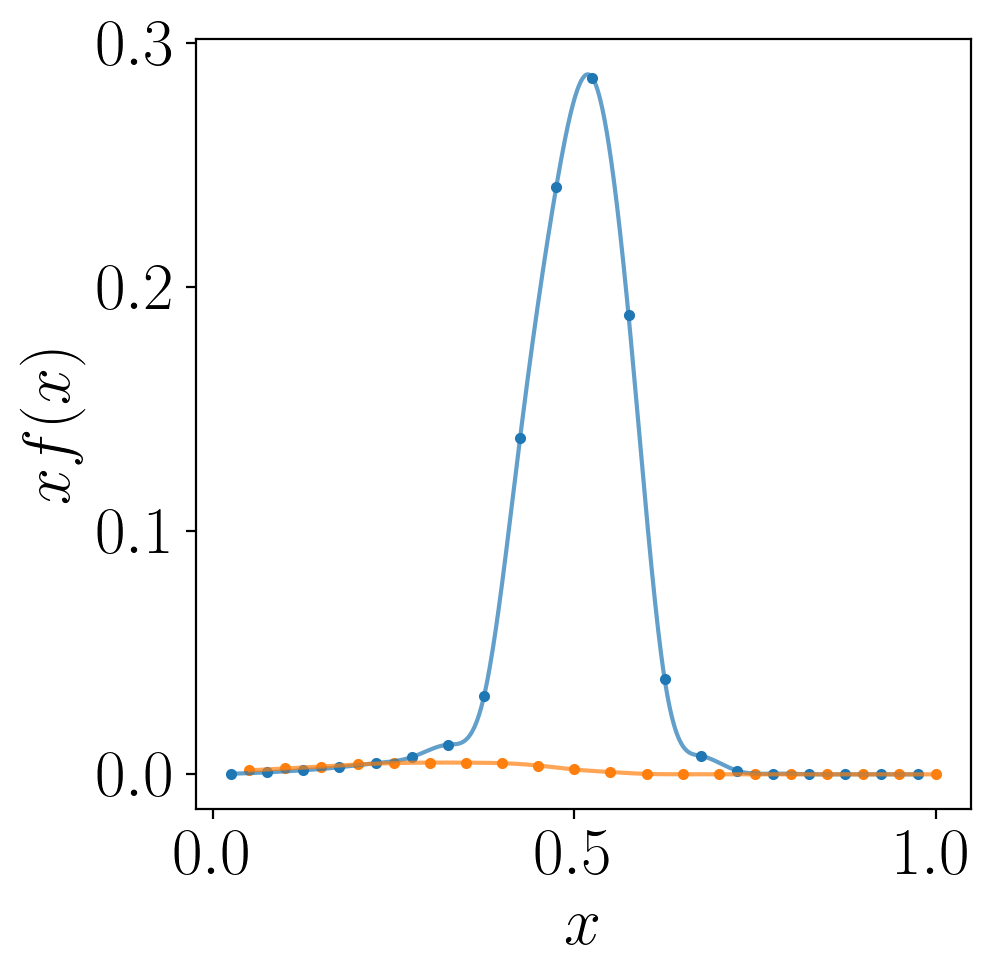

In [146]:
state = 0
psi = renormalized_eigenvectors[state]
res = max_res

x_fermion = np.array([k/res for k in np.arange(1/2, res, 1)])
fermion_pdf = x_fermion* np.real(pdf(res, psi, 'fermion'))

x_boson = np.array([k/res for k in np.arange(1, res + 1, 1)])
boson_pdf = x_boson * np.real(pdf(res, psi, 'boson'))

dx = 0.001
degree = 2

smooth_x_range_fermion = np.arange(min(x_fermion) + dx, max(x_fermion) - dx, dx)
smooth_x_range_boson = np.arange(min(x_boson) + dx, max(x_boson) - dx, dx)

interp_func_fermion = CubicSpline(x_fermion, fermion_pdf)
interp_func_boson = CubicSpline(x_boson, boson_pdf)

smooth_fermion_pdf = interp_func_fermion(smooth_x_range_fermion)
smooth_boson_pdf = interp_func_boson(smooth_x_range_boson)

plt.figure(figsize = (5,5), dpi = 200)


plt.scatter(x_fermion, fermion_pdf, marker = '.', label = r'$f$')
plt.plot(smooth_x_range_fermion, smooth_fermion_pdf, alpha = 0.7)

plt.scatter(x_boson, boson_pdf, marker = '.', label = f'$b$')
plt.plot(smooth_x_range_boson, smooth_boson_pdf, alpha = 0.7)
plt.plot([], [], color = 'white', label = f"$M^2 = {round(renormalized_eigenvalues[state][0], 3)}$")


# plt.legend()
plt.xlabel(f'$x$')
plt.ylabel(f'$xf(x)$')
# plt.savefig("../pdf.pdf")
# plt.ylim(-0.1, 1.1)
# plt.title(f"Yukawa $Q = {baryon_number}$ bound state PDF")
# plt.title(f"$g = {g}, m = {mf}, \mu = {mb}$")

In [58]:
mf = 1
mb = 0.5
g = 1
t = 1e-7

resolutions = np.arange(2, 20, 2)
grounds = []

for res in resolutions:
    print("--- K = ", res, " ---")
    basis = (
        get_Q_nonzero_sector_basis(resolution=res, n_fermions = 2, n_bosons = 0)
        + get_Q_nonzero_sector_basis(resolution=res, n_fermions = 2, n_bosons = 1)
    )
    hamiltonian = renormalized_yukawa_hamiltonian(
            res=res, t=t, treg=0, g=g, mf=mf, mb=mb
        )
    tmp_mat = generate_matrix_hermitian(hamiltonian, basis)
    vals = np.linalg.eigvalsh(tmp_mat)
    grounds.append(min(vals))
    

--- K =  2  ---
--- K =  4  ---
--- K =  6  ---
--- K =  8  ---
--- K =  10  ---
--- K =  12  ---
--- K =  14  ---
--- K =  16  ---
--- K =  18  ---


In [127]:
def f(x, a, b, c):
    return a + b/x + c/(x**2)

params = curve_fit(f, resolutions, grounds)

(0.0, 0.6)

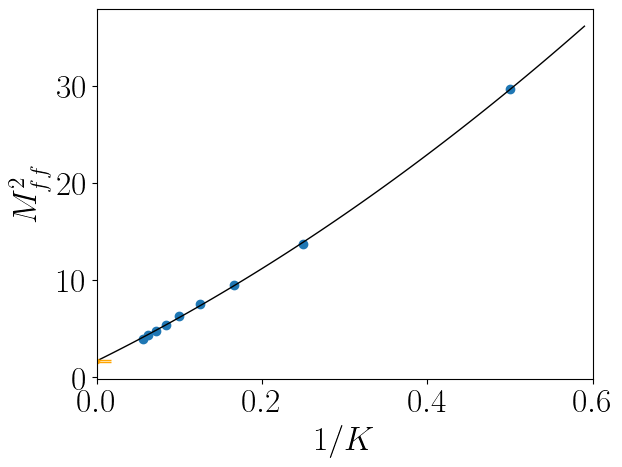

In [156]:
ks = np.arange(0, 0.6, 0.01)

plt.plot(ks, f(1/ks, params[0][0], params[0][1], params[0][2]), color = 'k', linewidth = 1)
plt.scatter(1/resolutions, grounds, alpha = 1)

x = 0
y = f(np.inf, params[0][0], params[0][1], params[0][2])
yerr = np.sqrt(np.diag(params[1]))[0]

plt.errorbar(x, y, yerr=yerr, fmt='.', color = 'orange', capsize=10, label="Data point")

plt.ylabel(r'$M^2_{ff}$')
plt.xlabel(f'$1/K$')

plt.xlim(0, 0.6)